In [1]:
import networkx as nx
import random
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import diags

########### FUNCIONES PARA REDES ###########

def create_fixed_degree_network(num_nodes_x, num_nodes_y, degree_x, degree_y,seed=None):

    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Define degree sequence
    degree_sequence = [degree_x] * num_nodes_x + [degree_y] * num_nodes_y

    # Check if the sum of degrees is even
    if sum(degree_sequence) % 2 != 0:
        raise ValueError("The sum of degrees must be even to form a valid graph.")

    # Generate a random graph using the configuration model
    G = nx.configuration_model(degree_sequence)

    # Convert the multigraph to a simple graph (remove parallel edges and self-loops)
    G = nx.Graph(G)
    G.remove_edges_from(nx.selfloop_edges(G))

    return G

def create_fixed_degree_network_v2(num_nodes_x, num_nodes_y, degree_x, degree_y, seed=None):
    """
    Creates a fixed degree network with the specified parameters, ensuring the graph is a single connected component.

    Parameters:
    - num_nodes_x (int): Number of nodes of type X.
    - num_nodes_y (int): Number of nodes of type Y.
    - degree_x (int): Degree of each node of type X.
    - degree_y (int): Degree of each node of type Y.
    - seed (int, optional): Random seed for reproducibility.

    Returns:
    - G (networkx.Graph): A simple, connected graph with the specified degree sequence.
    """
    # Set the seed for reproducibility
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Define degree sequence
    degree_sequence = [degree_x] * num_nodes_x + [degree_y] * num_nodes_y

    # Check if the sum of degrees is even
    if sum(degree_sequence) % 2 != 0:
        raise ValueError("The sum of degrees must be even to form a valid graph.")

    while True:
        # Generate a random graph using the configuration model
        G = nx.configuration_model(degree_sequence)

        # Convert the multigraph to a simple graph (remove parallel edges and self-loops)
        G = nx.Graph(G)
        G.remove_edges_from(nx.selfloop_edges(G))

        # Check if the graph is connected
        if nx.is_connected(G):
            return G

# Generate a random graph using the Erdős-Rényi model
def erdos_renyi_graph(num_nodes,probability):
    graph = nx.erdos_renyi_graph(n=num_nodes, p=probability)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)
    return graph

#watts_strogarz model (small-world)
def watts_strogarz_graph(n, k, p):
    graph = nx.watts_strogatz_graph(n,k,p,seed=100)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)

    return graph

#scale free networks
def barabasi_albert_graph(n,m):

    graph = nx.barabasi_albert_graph(n,m,seed=100)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)

    return graph

#stochastic_block_model
def stochastic_block_model(sizes, probs):

    graph = nx.stochastic_block_model(sizes, probs, seed=100)

    #keep the largest connected component
    largest_cc = max(nx.connected_components(graph), key=len)
    graph = graph.subgraph(largest_cc)

    return graph

In [2]:
########### FUNCIONES PARA SIMULACIÓN ###########
def RK4_FD(eq, fields, parameters, grids, dt, Nt, operators, t_rate): #implementa rouge-kutta
    t_grid = grids[0]
    x_grid = grids[1]
    y_grid = grids[2]
    fields_history = []
    time_grid = []
    for i in range(Nt - 1):
        old_fields = fields
        k_1 = equations_FD(eq, old_fields, t_grid[i], x_grid, y_grid, parameters, operators)
        k_2 = equations_FD(eq, old_fields + 0.5 * dt * k_1, t_grid[i], x_grid, y_grid, parameters, operators)
        k_3 = equations_FD(eq, old_fields + 0.5 * dt * k_2, t_grid[i], x_grid, y_grid, parameters, operators)
        k_4 = equations_FD(eq, old_fields + dt * k_3, t_grid[i], x_grid, y_grid, parameters, operators)
        new_fields = old_fields + dt * (k_1 + 2 * k_2 + 2 * k_3 + k_4) / 6
        fields = new_fields
        if i % t_rate == 0:
            fields_history.append(fields)
            time_grid.append(t_grid[i])
    return fields, fields_history, time_grid

def equations_FD(eq, field_slices, t_i, x_grid, y_grid, parameters, operators): #ecuaciones
    if eq == 'duffing':
        U = field_slices[0]
        V = field_slices[1]

        alpha = parameters[0]
        mu = parameters[1]
        gamma = parameters[2]
        k = parameters[3]
        w = parameters[4]
        DD = operators[0]

        ddU = DD @ U

        F = V
        G = - U + alpha * U ** 3 - U ** 5 - mu * V + gamma * np.cos(w * t_i) + k * ddU

        fields = np.array([F, G])
    return fields

def Der(D, f): #función de diferenciación
    d_f = D @ f
    return d_f

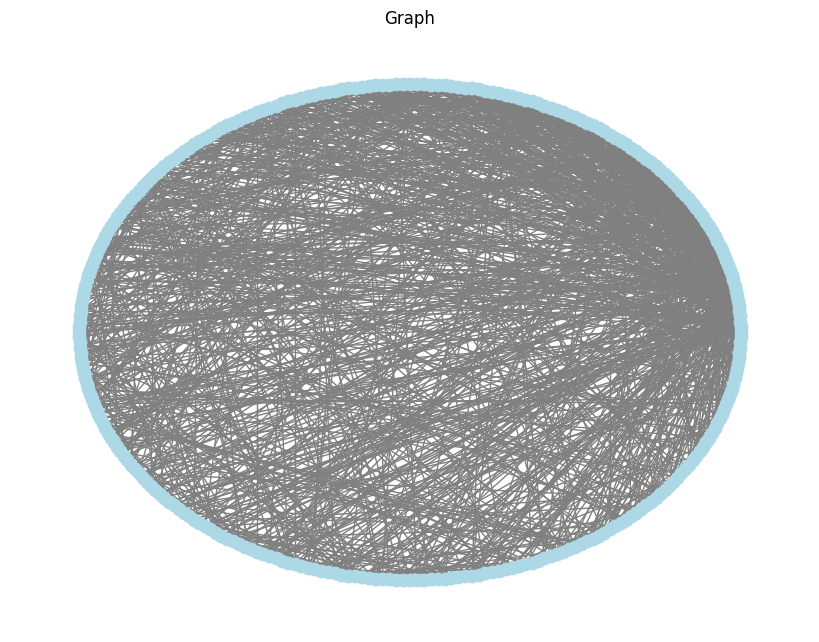

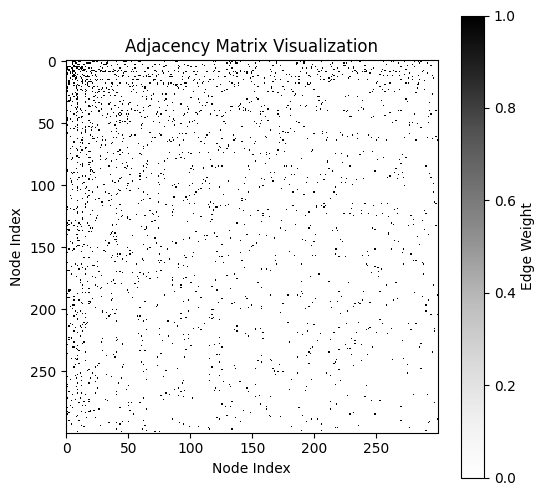

In [45]:
#graph = erdos_renyi_graph(1000, 0.1)
#graph = watts_strogarz_graph(300, 2, 0.5)
graph = nx.barabasi_albert_graph(300, 4)


# Get the adjacency matrix
adj_matrix = nx.adjacency_matrix(graph).toarray()

# Compute the Laplacian matrix
laplacian_matrix = nx.laplacian_matrix(graph).tocsc()

plt.figure(figsize=(8, 6))
pos = nx.circular_layout(graph)
nx.draw(graph, pos, with_labels=False, node_color="lightblue", edge_color="gray", node_size=80, font_size=10)

plt.title("Graph")
plt.show()
plt.close()

# Visualize the adjacency matrix as a lattice
plt.figure(figsize=(6, 6))
plt.imshow(adj_matrix, cmap='Greys', interpolation='none')
plt.colorbar(label="Edge Weight")
plt.title("Adjacency Matrix Visualization")
plt.xlabel("Node Index")
plt.ylabel("Node Index")
plt.show()

In [52]:
########### DEFINICIÓN DE PARAMETROS Y PREPARACION PARA SIMULACIÓN ###########

alpha = 0.4                                     # NONLINEAR COEFFICIENT
mu = 0.1                                        # DISSIPATION
gamma = 2.90#2.7  2.90                                  # DRIVE STRENGTH
k = 0.04 #0.4216 #0.028                                  # COUPLING (0.42)
w = 0.7
eq = 'duffing'
t_rate = 1

# Grid definition
N_nodes = 300
[tmin, tmax, dt] = [0, 5000, 0.05]
t_grid = np.arange(tmin, tmax + dt, dt)         # TEMPORAL GRID DEFINITION
[xmin, xmax, dx] = [0, N_nodes, 1]
x_grid = np.arange(xmin, xmax, dx)              # SPATIAL FRID DEFINITION

T = tmax
Nt = t_grid.shape[0]
Nx = x_grid.shape[0]

# Initial Conditions
U_init = 1.0 * np.ones(Nx)
arg_chimera = [87]                             # INITIAL QUIMERA INDEX
for i in arg_chimera:
    U_init[i] = 2.0
U_init = U_init + 0.0 * (np.random.rand(Nx) - 0.5)
V_init = 0.0 * np.random.rand(Nx)

# Empaquetamiento de parametros, campos y derivadas para integración
operators = [laplacian_matrix]
fields_init = [U_init, V_init]
grids = [t_grid, x_grid, 0]
parameters_np = np.array([alpha, mu, gamma, k, w])

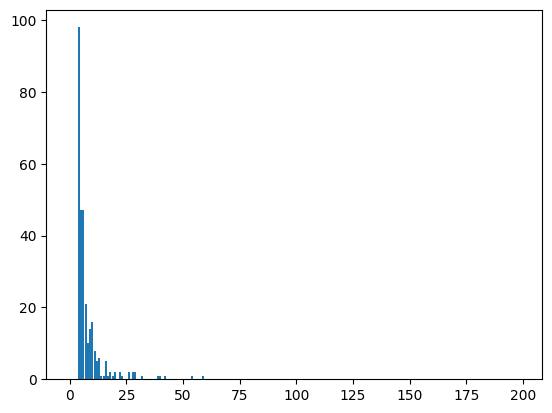

In [50]:
a = np.sum(adj_matrix, axis=0)
plt.hist(a, align="left", rwidth=0.9, bins=np.arange(0, 200) - 0.01)
plt.show()

In [53]:
final_fields, fields_history, time_grid = RK4_FD(eq, fields_init, parameters_np, grids, dt, Nt, operators, t_rate)

# Reobteniendo campos y variables
U = np.array(fields_history)[:, 0]
V = np.array(fields_history)[:, 1]
phase = np.arctan2(V, U)    #Harmonic oscillator can be writen as R * exp (i * phase) with R = SQRT(U ** 2 + V ** 2) and phase = arctan(V/U)
lightness = 1
U_light = U[0::lightness]
V_light = V[0::lightness]
phase_light_wraped = phase[0::lightness]
phase_light = np.unwrap(phase_light_wraped, axis=0)[0::lightness]
t_light = np.array(time_grid[0::lightness])
module = np.sqrt(U_light ** 2 + V_light ** 2) ## AMPLITUDE / MODULE